<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Code Functionality  Evals</h1>


This tests whether code is written correctly, without bugs, accomplishes the functionality you want, does not have syntax errors.

The purpose of this notebook is:

- to evaluate the performance of code fuctionality Eval
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [1]:
!pip install -qq arize-phoenix  "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [2]:
import nest_asyncio

nest_asyncio.apply()

In [3]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import pandas as pd
from phoenix.evals import (
    CODE_FUNCTIONALITY_PROMPT_RAILS_MAP,
    # To Add templates
    CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    OpenAIModel,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

TODO

In [4]:
df = pd.read_csv(
    "https://storage.googleapis.com/arize-assets/phoenix/evals/code-functionality/validated_python_code_samples_2.csv"
)

df.head()

,coding_instruction,code,is_well_coded
0,Create a neural network in Python from scratch that takes a 2D array of numbers as its input and predicts the sum of the numbers in each row.,"import numpy as np\n\nclass NeuralNetwork:\n def __init__(self, input_size):\n self.weights = np.random.rand(input_size, 1)\n self.bias = np.random.rand(1, 1)\n\n def predict(self, X):\n return np.dot(X, self.weights) + self.bias\n\n# Example Usage:\ninput_data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])\nnn = NeuralNetwork(input_size=input_data.shape[1])\npredictions = nn.predict(input_data)\nprint(predictions)",True
1,Generate a Python program to find the mode of the given list.,"from statistics import mode\n\ndef find_mode(input_list):\n try:\n result = mode(input_list)\n return result\n except StatisticsError:\n return ""No unique mode found""\n\n# Example Usage:\ndata_list = [1, 2, 2, 3, 4, 4, 5]\nmode_result = find_mode(data_list)\nprint(mode_result)",True
2,Develop a text summarizer in Python that takes a text input and returns a summary of the text in two sentences.,"from nltk import sent_tokenize\nfrom nltk.corpus import stopwords\nfrom nltk.stem import PorterStemmer\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.metrics.pairwise import cosine_similarity\n\ndef text_summarizer(text):\n sentences = sent_tokenize(text)\n stop_words = set(stopwords.words('english'))\n vectorizer = TfidfVectorizer()\n ps = PorterStemmer()\n\n def preprocess_sentence(sentence):\n words = [ps.stem(word) for word in sentence.split() if word.lower() not in stop_words]\n return ' '.join(words)\n\n preprocessed_sentences = [preprocess_sentence(sentence) for sentence in sentences]\n\n try:\n tfidf_matrix = vectorizer.fit_transform(preprocessed_sentences)\n sentence_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)\n except ValueError:\n return ""Input text is too short for summarization.""\n\n sentence_scores = [(index, sum(sentence_similarity[index])) for index in range(len(sentences))]\n sentence_scores = sorted(sentence_scores, key=lambda x: x[1], reverse=True)\n\n summary_sentences = [sentences[score[0]] for score in sentence_scores[:2]]\n summary = ' '.join(summary_sentences)\n\n return summary\n\n# Example Usage:\ninput_text = ""Your input text goes here. It should be a longer piece of text for meaningful summarization.""\nsummary_result = text_summarizer(input_text)\nprint(summary_result)",True
3,Create a program in Python to generate random passwords of 8 characters.,import random\nimport string\n\ndef generate_random_password():\n password_length = 8\n characters = string.ascii_letters + string.digits + string.punctuation\n password = ''.join(random.choice(characters) for i in range(password_length))\n return password\n\n# Example Usage:\nrandom_password = generate_random_password()\nprint(random_password),True
4,Design a python program to replace every occurrence of a word in a string with another word.,"def replace_word(string, word, replacement_word):\n return string.replace(word)\n\nprint(replace_word(""Hello hello world!"", ""hello"", ""welcome""))",False




```
# This is formatted as code
```

## Display Code Functionality Classification Template

View the default template used to code functionality. You can tweak this template and evaluate its performance relative to the default.

In [6]:
print(CODE_FUNCTIONALITY_PROMPT_TEMPLATE)


Code Evaluation Prompt:
TEST EDIT
-----------------------
Evaluate the provided code to determine its correctness in solving the given instruction.

Data:
-----
[Instruction]: {coding_instruction}
  Clearly define the task or problem that the code aims to address.

[Reference Code]: {code}
  Examine the submitted code for evaluation in the context of the provided instruction.

Evaluation:
-----------
Provide a concise response with a single word: either "bug_free" or "is_bug".
- "bug_free" signifies that the code correctly and efficiently solves the instruction with no bugs.
- "is_bug" indicates that the code either fails to meet the instruction requirements or contains bugs.

Example:
-----------

[Instruction]: Implement the Fibonacci sequence in Python.

[Reference Code]: 'def fibonacci(n):
    if n <= 1:
        return n
    else:
        return fibonacci(n - 1) + fibonacci(n - 2)

for i in range(10):
    print(fibonacci(i))'

[Output]: bug_free

Note: Assumptions can be made that

The template variables are:

- **coding_instruction:** What is the code supposed to do as an instruction
- **code:** The code to evaluate 


## Configure the LLM

Configure your OpenAI API key.

In [7]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

## LLM Evals: Code Functionality Classifications GPT-4
Run Code Functionality against a subset of the data.
Instantiate the LLM and set parameters.

In [8]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


In [9]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

## Run Code Func Classifications

Run code functionality classifications against a subset of the data.

In [10]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP.values())
relevance_classifications = llm_classify(
    dataframe=df,
    template=CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |██████████| 50/50 (100.0%) | ⏳ 00:08<00:00 |  6.20it/s


## Evaluate Classifications

Evaluate the predictions against human-labeled ground-truth code functionality labels.

              precision    recall  f1-score   support

    bug_free       0.96      0.81      0.88        31
      is_bug       0.75      0.95      0.84        19

    accuracy                           0.86        50
   macro avg       0.86      0.88      0.86        50
weighted avg       0.88      0.86      0.86        50



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

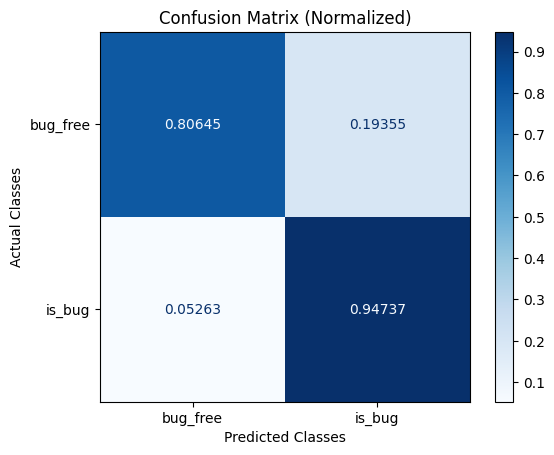

In [11]:
true_labels = df["is_well_coded"].map(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Classifications with explanations

When evaluating a dataset for code functionality, it can be useful to know why the LLM classified a document as relevant or irrelevant. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [12]:
small_df_sample = df.copy().sample(n=5).reset_index(drop=True)
relevance_classifications_df = llm_classify(
    dataframe=small_df_sample,
    template=CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
    verbose=True,
    concurrency=20,
)

Using prompt:


Code Evaluation Prompt:
-----------------------
Evaluate the provided code to determine its correctness in solving the given instruction.

Data:
-----
[Instruction]: {coding_instruction}
  Clearly define the task or problem that the code aims to address.

[Reference Code]: {code}
  Examine the submitted code for evaluation in the context of the provided instruction.

Evaluation:
-----------
Provide a concise response with a explanation and a single word LABEL: either "bug_free" or "is_bug".
- "bug_free" signifies that the code correctly and efficiently solves the instruction with no bugs.
- "is_bug" indicates that the code either fails to meet the instruction requirements or contains bugs.

Example:
-----------

[Instruction]: Implement the Fibonacci sequence in Python.

[Reference Code]: 'def fibonacci(n):
    if n <= 1:
        return n
    else:
        return fibonacci(n - 1) + fibonacci(n - 2)

for i in range(10):
    print(fibonacci(i))'

[Output]: bug_free

Note:

llm_classify |██        | 1/5 (20.0%) | ⏳ 00:02<00:11 |  2.97s/it

- Snapped 'is_bug' to rail: is_bug


llm_classify |████      | 2/5 (40.0%) | ⏳ 00:04<00:06 |  2.07s/it 

- Snapped 'is_bug' to rail: is_bug


llm_classify |████████  | 4/5 (80.0%) | ⏳ 00:05<00:00 |  1.06it/s 

- Snapped 'is_bug' to rail: is_bug
- Snapped 'bug_free' to rail: bug_free


llm_classify |██████████| 5/5 (100.0%) | ⏳ 00:09<00:00 |  2.07s/it

- Snapped 'bug_free' to rail: bug_free


llm_classify |██████████| 5/5 (100.0%) | ⏳ 00:10<00:00 |  2.07s/it


In [13]:
# Let's view the data
merged_df = pd.merge(
    small_df_sample, relevance_classifications_df, left_index=True, right_index=True
)
merged_df[["coding_instruction", "code", "label", "explanation"]].head()

,coding_instruction,code,label,explanation
0,Write a Python program to optimize a given code and make it run faster.,"def optimize_code(code):\n optimized_code = """"\n lines = code.splitlines()\n indentation_level = 0\n\n for line in lines:\n # Remove redundant white space and apply proper indentation\n optimized_code += "" "" * indentation_level + line.strip() + ""\n""\n\n # Increment/Decrement indentation level \n if line.endswith("":""):\n indentation_level += 4\n else:\n if line[0] not in [""#"", """"]:\n indentation_level -= 4\n indentation_level = max(indentation_level, 0) # prevent it going below 0\n\n return optimized_code",is_bug,"The instruction asks for a Python program that optimizes a given code to make it run faster. However, the provided code does not perform any optimization to make the code run faster. Instead, it reformats the code by removing redundant white spaces and adjusting indentation. This does not improve the performance of the code, it only makes it more readable. Therefore, the code does not meet the requirements of the instruction."
1,Develop a Python program to estimate the value of PI using Leibniz's formula.,"def estimate_pi(n_terms: int) -> float:\n numerator: float = 4.0\n denominator: float = 1.0\n operation: float = 1.0\n pi: float = 0.0\n\n for _ in range(n_terms):\n pi += operation * (numerator / denominator)\n denominator += 2.0\n operation *= -1.0\n\n return pi\n\n\nif __name__ == ""__main__"":\n print(estimate_pi(1000))",bug_free,"The provided Python code correctly implements the Leibniz's formula for estimating the value of PI. The function estimate_pi takes an integer n_terms as input, which represents the number of terms in the Leibniz's series to be used for the estimation. The function then initializes four variables: numerator, denominator, operation, and pi. The numerator is always 4.0, the denominator starts at 1.0 and is incremented by 2.0 after each term, the operation alternates between 1.0 and -1.0 to account for the alternating signs in the series, and pi is the running total of the series. The function then enters a loop that runs for n_terms iterations. In each iteration, the function adds the current term (operation * (numerator / denominator)) to pi, increments the denominator by 2.0, and flips the sign of operation. After the loop, the function returns the estimated value of PI. Therefore, the code is bug-free."
2,Construct a python script to display the frequency of each words appearing in a document,"from collections import Counter\n \nwith open('text.txt', 'r') as f:\n data = f.read().lower().split()\n \nword_counter = Counter(data)\n \n# Print the sorted most common 10 words\nfor word, count in word_counter.most_common(10):\n print('{}: {}'.format(word, count))",bug_free,"The provided code correctly opens a text file, reads its content, converts it to lowercase, splits it into words, and counts the frequency of each word using the Counter class from the collections module. It then prints the 10 most common words along with their frequencies. The code is correct and efficient in solving the given instruction, which is to display the frequency of each word appearing in a document. However, it assumes that the file 'text.txt' exists and is in the same directory as the script, and it does not handle punctuation or special characters, which could be considered part of the words. But as per the given instruction, it is not explicitly required to handle these cases."
3,Write a machine learning model in Python to predict the classification of the given email.,"import pandas as pd\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.naive_bayes import MultinomialNB\n\n# read in the data\ndf = pd.read_csv('data.csv')\n\n# split the data into training and test sets\nX_train, X_test, y_train, y_test = train_test_split(df['email_text'], df['class'], test_size=0.2)\n\n# create the TF-IDF vectorizer and

## LLM Evals: code functionality Classifications GPT-3.5 Turbo
Run Code functionality against a subset of the data using GPT-3.5. GPT-3.5 can significantly speed up the classification process. However there are tradeoffs as  we will see below.

In [14]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


In [15]:
rails = list(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP.values())
relevance_classifications = llm_classify(
    dataframe=df,
    template=CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |██████████| 50/50 (100.0%) | ⏳ 00:10<00:00 |  4.59it/s


              precision    recall  f1-score   support

    bug_free       0.95      0.68      0.79        31
      is_bug       0.64      0.95      0.77        19

    accuracy                           0.78        50
   macro avg       0.80      0.81      0.78        50
weighted avg       0.84      0.78      0.78        50



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

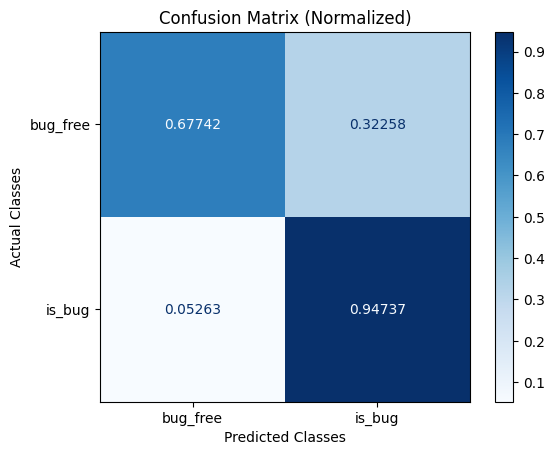

In [16]:
true_labels = df["is_well_coded"].map(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Preview: Running with GPT-4 Turbo

In [17]:
model = OpenAIModel(model_name="gpt-4-1106-preview")
classifications = llm_classify(
    dataframe=df,
    template=CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    model=model,
    rails=list(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP.values()),
    concurrency=20,
)["label"].tolist()

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


llm_classify |██████████| 50/50 (100.0%) | ⏳ 00:12<00:00 |  4.16it/s


              precision    recall  f1-score   support

    bug_free       1.00      0.77      0.87        31
      is_bug       0.73      1.00      0.84        19

    accuracy                           0.86        50
   macro avg       0.87      0.89      0.86        50
weighted avg       0.90      0.86      0.86        50



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

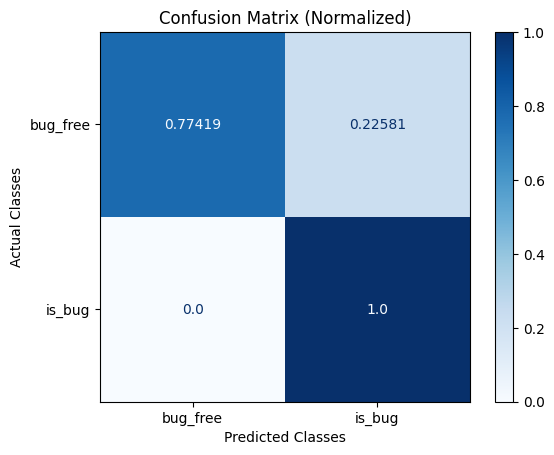

In [18]:
true_labels = df["is_well_coded"].map(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)